In [89]:
%matplotlib inline

import os
import glob
from pathlib import Path
import ssl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import tensorflow_datasets as tfds


# if using remote server
current_path = os.path.basename(os.path.normpath(os.getcwd()))
DIR = "traffic-signs-v1"
if(current_path != DIR):
	os.chdir(DIR)

SEED=1
BATCH_SIZE=64
INPUT_DIR = "./input/"
DATA_DIR = f"{INPUT_DIR}/traffic_Data/DATA/"
IMG_WH = 128

#tf.random.set_seed(SEED)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

# gpu optimizations
tf.config.optimizer.set_jit(True)

# with tf.device('/gpu:0'):
#     a = tf.constant([2.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 5.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)

# tf.compat.v1.disable_eager_execution()
# with tf.compat.v1.Session() as sess:
#     print (sess.run(c))

Name: /physical_device:GPU:0   Type: GPU


In [90]:
labels_df = pd.read_csv(f'{INPUT_DIR}labels.csv')
print(labels_df.head())

#Create a label map
label_map = dict(labels_df.values)
print(len(label_map))

   ClassId                  Name
0        0   Speed limit (5km/h)
1        1  Speed limit (15km/h)
2        2  Speed limit (30km/h)
3        3  Speed limit (40km/h)
4        4  Speed limit (50km/h)
58


In [91]:
image_list = list(Path(DATA_DIR).glob(r'**/*.png'))
labels = list(map(lambda path: os.path.split(os.path.split(path)[0])[1], image_list))

#Create dataframe with path of images and labels
image_series = pd.Series(image_list).astype(str)
labels_series = pd.Series(labels).astype(str)
frame = {'image':image_series, 'label':labels_series}
image_df = pd.DataFrame(frame)
print(image_df.sample(5))

                                          image label
1253  input\traffic_Data\DATA\26\026_1_0015.png    26
2587  input\traffic_Data\DATA\38\038_1_0003.png    38
1503    input\traffic_Data\DATA\28\028_0173.png    28
2103    input\traffic_Data\DATA\30\030_0023.png    30
724   input\traffic_Data\DATA\16\016_1_0006.png    16


<AxesSubplot:xlabel='label', ylabel='count images'>

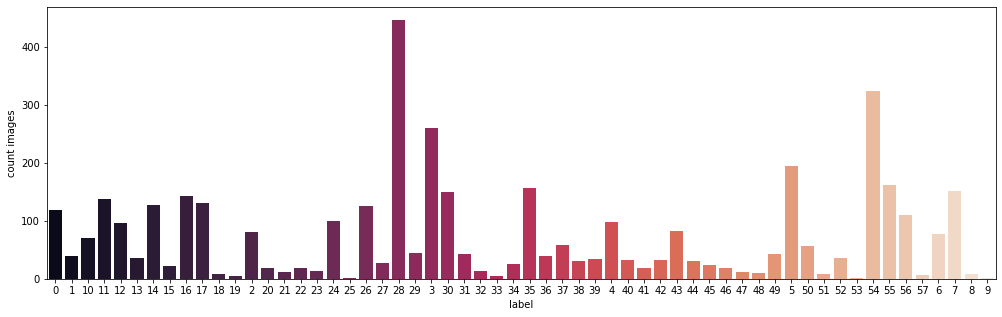

In [92]:
count_labels = image_df.groupby(['label']).size()
plt.figure(figsize=(17,5))
plt.ylabel('count images')
sns.barplot(x=count_labels.index, y=count_labels, palette="rocket")

In [93]:
SPLIT_MINIMUM_COUNT = 10

In [94]:
def split_dataset(df, rate=SPLIT_MINIMUM_COUNT):
	"""
	Allocate a  dataset that has at least SPLIT_MINIMUM_COUNT_IMAGES of images
	
	split_df: dataframe for train
	train1_df: dataframe for drop
	"""

	count_labels = df.groupby(['label']).size()
	count_labels_df = count_labels.to_frame(name='count_images').reset_index()

	drop_label_list = list(
		count_labels_df['label'].\
		loc[count_labels_df['count_images']<SPLIT_MINIMUM_COUNT]
	)

	drop_df = df.copy()
	split_df = df.copy()

	for index, row in df.iterrows():
		if str(row.label) in drop_label_list:
			split_df = split_df.drop(index)
		else:
			drop_df = drop_df.drop(index)

	return split_df, drop_df

def custom_train_test_split(df):

	labels = df.label.unique()
	test_df = pd.DataFrame()

	for label in labels:
		label_samples = df.loc[df.label==label]
		test_df = pd.concat([test_df,label_samples.sample(len(label_samples)//10+1,random_state=SEED)])
	
	train_df = df.drop(list(test_df.index), axis=0)
	test_df = test_df.sample(frac=1, random_state=SEED)
	train_df = train_df.sample(frac=1, random_state=SEED)

	return train_df, test_df

image_df, _ = split_dataset(image_df)
#train_df, test_df = custom_train_test_split(split_df)
train, val = custom_train_test_split(image_df)

In [95]:
train_labels = train.groupby(['label']).size()
NUM_CLASSES = len(train_labels)
print(NUM_CLASSES)

49


In [96]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='constant',
    #shear_range=0.2,
    zoom_range=0.3,
	rescale=1./255
)

In [97]:
train_dataset = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='image',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(IMG_WH, IMG_WH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    #seed=SEED
)

val_dataset = train_generator.flow_from_dataframe(
    dataframe=val,
    x_col='image',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(IMG_WH, IMG_WH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    #seed=SEED,
)

Found 3683 validated image filenames belonging to 49 classes.
Found 443 validated image filenames belonging to 49 classes.


In [98]:
map_labels = (train_dataset.class_indices)
map_labels = dict((v,k) for k,v in map_labels.items())

def model_to_label(n):
	return label_map[int(map_labels[np.argmax(n, axis=0)])]

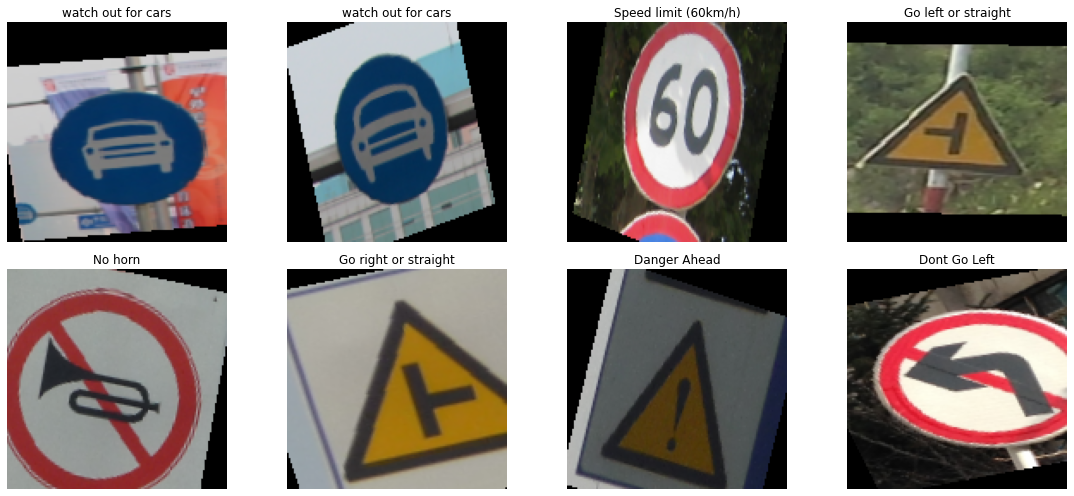

In [99]:
#plot images
fig, axes = plt.subplots(2,4, figsize=(16, 7))
images, labels = train_dataset[0] # first batch
images2, labels2 = val_dataset[0] # first batch
for idx, ax in enumerate(axes.flat):
	if(idx < 4):
		image, label = images[idx], labels[idx]
	if(idx >= 4):
		image, label = images2[idx], labels2[idx]
	ax.imshow(image)
	ax.set_title(model_to_label(label))
	ax.axis("off")
plt.tight_layout()
plt.show()

In [100]:
#create model
def create_model(input_shape=(IMG_WH,IMG_WH,3,)):
	"""
	load EfficientNet without last layer and 
	add Dense and ouput Dense with NUM_CLASSES units

	"""

	layers = tf.keras.layers
	model = tf.keras.Sequential()

	model.add(layers.Input(shape=input_shape))
	model.add(layers.BatchNormalization())

	# base_model = tf.keras.applications.VGG16(
	# 	include_top=False,
	# 	weights='imagenet',
	# 	input_tensor = input_tensor
	# )
	# base_model.trainable = False
	# model.add(base_model)
	# #model.add(input_tensor)

	# model.add(layers.Flatten())
	# model.add(layers.Dense(units=512, activation="relu"))
	# model.add(layers.Dense(units=256, activation="relu"))

	model.add(layers.Conv2D(filters=64, kernel_size=5, activation="relu", padding="same"))
	model.add(layers.MaxPool2D(pool_size=2))
	model.add(layers.Conv2D(filters=64, kernel_size=5, activation="relu", padding="same"))
	model.add(layers.MaxPool2D(pool_size=2))
	model.add(layers.Dropout(0.2))

	model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"))
	model.add(layers.MaxPool2D(pool_size=2))
	model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"))
	model.add(layers.MaxPool2D(pool_size=2))
	model.add(layers.Dropout(0.2))

	model.add(layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"))
	model.add(layers.MaxPool2D(pool_size=2))
	model.add(layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"))
	model.add(layers.MaxPool2D(pool_size=2))
	model.add(layers.Dropout(0.2))

	model.add(layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding="same"))
	model.add(layers.MaxPool2D(pool_size=2))
	model.add(layers.Dropout(0.2))

	model.add(layers.Flatten())

	model.add(layers.Dense(units=512, activation="relu"))
	model.add(layers.Dense(units=128, activation="relu"))
	
	model.add(layers.Dropout(0.2))
	model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
		
	return model

In [101]:
model = create_model()
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'],
)

In [102]:
callbacks = [
	tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
	tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-7, patience=2, mode='min', verbose=1, factor=0.1),
]

with tf.device('/gpu:0'):
	history = model.fit(
		train_dataset,
		epochs=100,
		validation_data=val_dataset,
		callbacks=callbacks
	)

Epoch 1/100
58/58 [==============================] - 21s 323ms/step - loss: 3.4061 - acc: 0.1045 - val_loss: 3.5217 - val_acc: 0.1196 - lr: 0.0010
Epoch 2/100
58/58 [==============================] - 19s 323ms/step - loss: 2.7139 - acc: 0.2384 - val_loss: 2.7038 - val_acc: 0.2889 - lr: 0.0010
Epoch 3/100
58/58 [==============================] - 15s 253ms/step - loss: 2.3225 - acc: 0.3416 - val_loss: 2.4355 - val_acc: 0.3770 - lr: 0.0010
Epoch 4/100
58/58 [==============================] - 15s 253ms/step - loss: 1.8929 - acc: 0.4268 - val_loss: 1.7231 - val_acc: 0.4582 - lr: 0.0010
Epoch 5/100
58/58 [==============================] - 15s 254ms/step - loss: 1.6887 - acc: 0.4632 - val_loss: 1.6464 - val_acc: 0.4786 - lr: 0.0010
Epoch 6/100
58/58 [==============================] - 15s 253ms/step - loss: 1.5218 - acc: 0.4923 - val_loss: 1.5210 - val_acc: 0.5395 - lr: 0.0010
Epoch 7/100
58/58 [==============================] - 15s 254ms/step - loss: 1.4288 - acc: 0.5246 - val_loss: 1.4058 - 

In [103]:
# Pruning
score = model.evaluate(val_dataset, verbose=0)
print(f'Regular CNN - Test loss: {score[0]} / Test accuracy: {score[1]}')

# Load functionality for adding pruning wrappers
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Finish pruning after 5 epochs
pruning_epochs = 5
num_images = len(train_dataset[0][0])
end_step = np.ceil(num_images / BATCH_SIZE).astype(np.int32) * pruning_epochs

# Define pruning configuration
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.40,
                                                               final_sparsity=0.70,
                                                               begin_step=0,
                                                               end_step=end_step)
}
model_fast = prune_low_magnitude(model, **pruning_params)

# Recompile the model
model_fast.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Model callbacks
callbacks = [
	tfmot.sparsity.keras.UpdatePruningStep()
]

# Fitting data
with tf.device('/gpu:0'):
	model_fast.fit(train_dataset,
						batch_size=BATCH_SIZE,
						epochs=pruning_epochs,
						callbacks=callbacks,
						validation_data=val_dataset,
						)

# Generate generalization metrics
score_pruned = model_fast.evaluate(val_dataset, verbose=0)
print(f'Pruned CNN - Test loss: {score_pruned[0]} / Test accuracy: {score_pruned[1]}')
print(f'Regular CNN - Test loss: {score[0]} / Test accuracy: {score[1]}')

Regular CNN - Test loss: 0.1961604803800583 / Test accuracy: 0.9367945790290833
Epoch 1/5
58/58 [==============================] - 21s 263ms/step - loss: 0.3495 - accuracy: 0.8876 - val_loss: 0.3720 - val_accuracy: 0.8871
Epoch 2/5
58/58 [==============================] - 16s 274ms/step - loss: 0.4132 - accuracy: 0.8781 - val_loss: 0.2603 - val_accuracy: 0.9255
Epoch 3/5
58/58 [==============================] - 16s 271ms/step - loss: 0.3399 - accuracy: 0.8947 - val_loss: 0.2680 - val_accuracy: 0.9029
Epoch 4/5
58/58 [==============================] - 15s 264ms/step - loss: 0.3354 - accuracy: 0.9023 - val_loss: 0.2764 - val_accuracy: 0.9120
Epoch 5/5
58/58 [==============================] - 15s 262ms/step - loss: 0.2893 - accuracy: 0.9139 - val_loss: 0.2264 - val_accuracy: 0.9278
Pruned CNN - Test loss: 0.19721156358718872 / Test accuracy: 0.9300225973129272
Regular CNN - Test loss: 0.1961604803800583 / Test accuracy: 0.9367945790290833


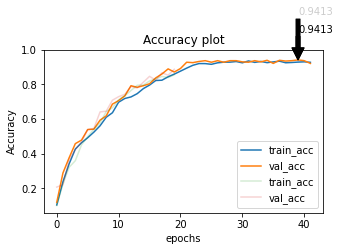

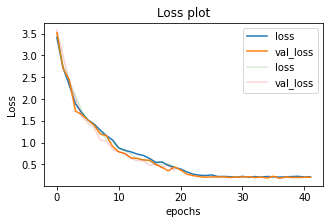

In [104]:
try:
    old_history
except NameError:
    old_history = history

plt.figure(figsize=(5,3))
plt.plot(history.history['acc'], label='train_acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.plot(old_history.history['acc'], label='train_acc', alpha=0.2)
plt.plot(old_history.history['val_acc'], label='val_acc', alpha=0.2)
plt.title('Accuracy plot')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.ylim(top=1)

# plot maximum point
ymax = max(history.history['val_acc'])
xpos = history.history['val_acc'].index(ymax)

plt.annotate(round(ymax,4), xy=(xpos, ymax), xytext=(xpos, 1.1), arrowprops=dict(facecolor='black'))
plt.annotate(round(ymax,4), xy=(xpos, ymax), xytext=(xpos, 1.2), arrowprops=dict(facecolor='black'), alpha=0.2)


plt.legend()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(old_history.history['loss'], label='loss', alpha=0.2)
plt.plot(old_history.history['val_loss'], label='val_loss', alpha=0.2)
plt.title('Loss plot')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

old_history = history

In [105]:
predictions = model_fast.predict(val_dataset[0][0])

wrong_info = [[val_dataset[0][0][i],model_to_label(predictions[i]),model_to_label(val_dataset[0][1][i])] for i,v in enumerate(predictions) if np.argmax(predictions[i])!=np.argmax(val_dataset[0][1][i], axis=0)]

2/2 [==============================] - 1s 47ms/step


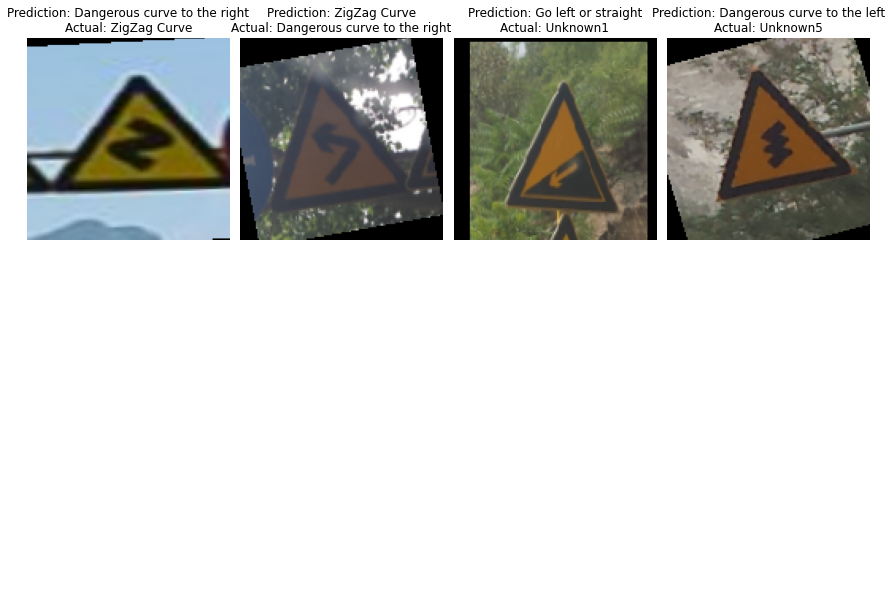

In [106]:
#plot wrong images and their labels
if(len(wrong_info) > 0):
	fig, axes = plt.subplots(len(wrong_info)//4+1, min(len(wrong_info), 4),figsize=(12, 9))
	for idx, ax in enumerate(axes.flat):
		if(len(wrong_info) <= idx):
			ax.axis("off")
			continue
		wimage, wlabel, rlabel = wrong_info[idx]
		ax.imshow(wimage)
		ax.set_title("Prediction: "+wlabel+"\n"+"Actual: "+rlabel)
		ax.axis("off")
	plt.tight_layout()
	plt.show()
else:
	print("Zero errors in batch 1")